In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import random
import re
import string

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt

nltk.download("stopwords")
nltk.download("punkt")

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/kaggle/input/alldatafiltered/AllDataFilteredNoBody.csv
/kaggle/input/alldatafiltered/AllDataFiltered.csv
/kaggle/input/notcombined/r_udub_posts_filtered.csv


In [30]:
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens


In [31]:
text_columns = ["combined_text"]

df_raw = pd.read_csv("/kaggle/input/alldatafiltered/AllDataFiltered.csv")
df = df_raw.copy()
df["combined_text"] = df["combined_text"].fillna("")

for col in text_columns:
    df[col] = df[col].astype(str)

# Create text column based on title, description, and content
df["text"] = df[text_columns].apply(lambda x: " | ".join(x), axis=1)
df["tokens"] = df["text"].map(lambda x: clean_text(x, word_tokenize, stopwords.words("english")))

# Remove duplicated after preprocessing
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

# Remove empty values and keep relevant columns
df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["text", "tokens"]]

docs = df["text"].values
tokenized_docs = df["tokens"].values

print(f"Original dataframe: {df_raw.shape}")
print(f"Pre-processed dataframe: {df.shape}")

Original dataframe: (10584, 2)
Pre-processed dataframe: (10536, 2)


In [32]:
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=SEED)

In [33]:
model.wv.most_similar("math")

[('series', 0.9814079403877258),
 ('physics', 0.9748091697692871),
 ('cse', 0.9660899639129639),
 ('phys', 0.9631554484367371),
 ('intro', 0.9609020948410034),
 ('gen', 0.9588232040405273),
 ('calc', 0.9536909461021423),
 ('chem', 0.9536144137382507),
 ('stat', 0.953223705291748),
 ('econ', 0.9492281675338745)]

In [34]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(tokenized_docs, model=model)
len(vectorized_docs), len(vectorized_docs[0])



(10536, 100)

In [35]:
def mbkmeans_clusters(
	X, 
    k, 
    mb, 
    print_silhouette_values, 
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [36]:
clustering, cluster_labels = mbkmeans_clusters(
	X=vectorized_docs,
    k=10,
    mb=500,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10
Silhouette coefficient: 0.13
Inertia:10500.536175893752
Silhouette values:
    Cluster 4: Size:2253 | Avg:0.22 | Min:-0.00 | Max: 0.43
    Cluster 0: Size:1414 | Avg:0.20 | Min:-0.03 | Max: 0.43
    Cluster 2: Size:848 | Avg:0.17 | Min:0.02 | Max: 0.38
    Cluster 8: Size:805 | Avg:0.12 | Min:-0.05 | Max: 0.35
    Cluster 7: Size:389 | Avg:0.10 | Min:-0.13 | Max: 0.35
    Cluster 9: Size:1119 | Avg:0.09 | Min:-0.13 | Max: 0.33
    Cluster 6: Size:730 | Avg:0.07 | Min:-0.18 | Max: 0.33
    Cluster 5: Size:906 | Avg:0.07 | Min:-0.08 | Max: 0.30
    Cluster 3: Size:1278 | Avg:0.06 | Min:-0.12 | Max: 0.29
    Cluster 1: Size:794 | Avg:0.04 | Min:-0.14 | Max: 0.27


In [37]:
print("Most representative terms per cluster (based on centroids):")
for i in range(10):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):
Cluster 0: wwu transfers intend considered choose 
Cluster 1: graduation nope normal studying deans 
Cluster 2: ns doable retake retaking ess 
Cluster 3: excited hopeful rsos joining duchess 
Cluster 4: crazy bother everytime changes enjoying 
Cluster 5: prepare ocean dxarts hsteu ace 
Cluster 6: bachelors undeclared ece ce nursing 
Cluster 7: vlpa biol fig retake elective 
Cluster 8: hardest adding engr mcd aps 
Cluster 9: gym cheap bring nearby store 


In [38]:
test_cluster = 5
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:3]:
    print(docs[d])
    print("-------------")

pol s 285 questions i’m taking pol s 285 with professor smith this winter and reading the canvas page apparently there’s “set of section assignments where students will develop their programming and data analysis skills”, if there’s anyone out there that has taken this class could you let me know what this means. i’m majoring in polysci to avoid any computer/tech stuff so this is kind of throwing me off. thanks.
-------------
how to take notes does anyone have any good note taking tips? i have always used hand notes but plan to switch to using my laptop for efficiency sake. any great tips or certain ways people have taken notes that work for them?
-------------
stat 311 i plan on registering for stat 311, but i’m not sure which section i should choose. 
section a has live instruction (lectures and quiz sections), whereas section b is asynchronous. in general, i’m able to learn by both ways pretty well. i was just wondering if anyone has any thoughts or opinions on it (from experience).

In [39]:
# After filtering or processing, reset the index to create a unique identifier
df = df.reset_index(drop=True)

# Assuming df_raw is your original DataFrame
df_raw = df_raw.reset_index(drop=True)

# Now you can safely add cluster labels because both DataFrames align
df['cluster'] = cluster_labels

# If you need to merge additional information from df_raw into df
df_full = df_raw.join(df['cluster'])

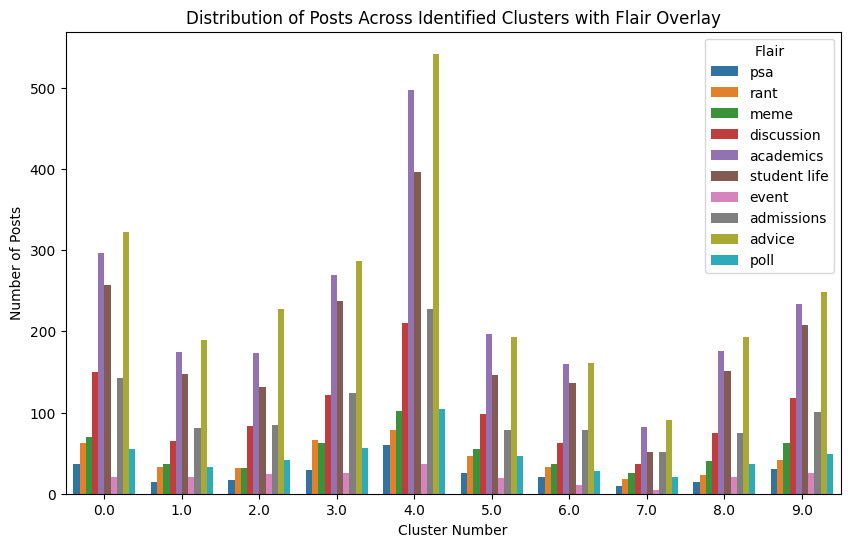

In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_full, x='cluster', hue='link_flair_text')
plt.title('Distribution of Posts Across Identified Clusters with Flair Overlay')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Posts')
plt.legend(title='Flair', loc='upper right')
plt.show()

In [42]:
print(df_full)

                                           combined_text link_flair_text  \
0      for everyone, whether you're worried about cov...             psa   
1              and people wonder why the virus spreads…             rant   
2                                           r/udub mods             meme   
3      thoughts on madrona? i have an emotional suppo...      discussion   
4      soc 222 anyone has took or taking soc222(socio...       academics   
...                                                  ...             ...   
10579  uw or cwru (case western) for pre med? pre-med...          advice   
10580  uw religious studies courses hi, entering uw w...       academics   
10581  spanish requirements changing?  i’m a prospect...       academics   
10582  anyone going to seattle international film fes...      discussion   
10583  microbio and weed-out classes i know this subr...          advice   

       cluster  
0          3.0  
1          0.0  
2          3.0  
3          4.0  
4 

In [49]:
print(df_raw)

                                           combined_text link_flair_text
0      for everyone, whether you're worried about cov...             psa
1              and people wonder why the virus spreads…             rant
2                                           r/udub mods             meme
3      thoughts on madrona? i have an emotional suppo...      discussion
4      soc 222 anyone has took or taking soc222(socio...       academics
...                                                  ...             ...
10579  uw or cwru (case western) for pre med? pre-med...          advice
10580  uw religious studies courses hi, entering uw w...       academics
10581  spanish requirements changing?  i’m a prospect...       academics
10582  anyone going to seattle international film fes...      discussion
10583  microbio and weed-out classes i know this subr...          advice

[10584 rows x 2 columns]


In [50]:
def evaluate_clusters(X, labels):
    print(f"Silhouette Score: {silhouette_score(X, labels):.2f}")

for i in range(5, 30, 5):
    for j in range(100, 1000, 100):
        for k in range(1, 14, 2):
            model = Word2Vec(sentences=tokenized_docs, window=i, vector_size=j, workers=k, seed=SEED)
            vectors = vectorize(tokenized_docs, model)
            X_train, _, y_train, _ = train_test_split(vectors, df_full['link_flair_text'], test_size=0.2, random_state=42)
            clustering_model, cluster_labels = mbkmeans_clusters(X_train, k=10, mb=500, print_silhouette_values=False)
            evaluate_clusters(X_train, cluster_labels)


RuntimeError: you must first build vocabulary before training the model

In [ ]:
def evaluate_clusters(X, labels):
    print(f"Silhouette Score: {silhouette_score(X, labels):.2f}")

for i in range(5, 30, 5):
    for j in range(100, 1000, 100):
        for k in range(1, 14, 2):
            model = Word2Vec(sentences=tokenized_docs, window=i, vector_size=j, workers=k, seed=SEED)
            vectors = vectorize(tokenized_docs, model)
            X_train, _, y_train, _ = train_test_split(vectors, df_raw['link_flair_text'], test_size=0.2, random_state=42)
            clustering_model, cluster_labels = mbkmeans_clusters(X_train, k=10, mb=500, print_silhouette_values=False)
            evaluate_clusters(X_train, cluster_labels)
